In [19]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time handling
import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd

# Modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# SHAP for explainability
import shap

# Plotting utilities
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [20]:

from datetime import timedelta
from datetime import date
import random



def simulate_central_scenario(seed=1234):
    np.random.seed(seed)
    
    # Policy data
    # ~~~~~~~~~~~~~~~~~
    
    # Create a date range for UW dates from 2016-01-01 to 2017-12-31
    date_UW = pd.date_range(start="2016-01-01", end="2017-12-31", freq='D')
    dt_policydates = pd.DataFrame({'date_UW': date_UW})
    
    # number of policies per day follows Poisson(700)
    dt_policydates['policycount'] = np.random.poisson(lam=700, size=len(dt_policydates))
    
    # Add date_lapse and expodays (days between UW date and UW date + 1 year)
    dt_policydates['date_lapse'] = dt_policydates['date_UW'] + pd.DateOffset(years=1)
    dt_policydates['expodays'] = (dt_policydates['date_lapse'] - dt_policydates['date_UW']).dt.days
    
    # pol_prefix for unique id construction
    dt_policydates['pol_prefix'] = (
        dt_policydates['date_UW'].dt.year * 10000 +
        dt_policydates['date_UW'].dt.month * 100 +
        dt_policydates['date_UW'].dt.day
    )
    
    # Policy covers
    dt_policydates['Cover_B'] = np.round(dt_policydates['policycount'] * 0.25).astype(int)
    dt_policydates['Cover_BO'] = np.round(dt_policydates['policycount'] * 0.45).astype(int)
    dt_policydates['Cover_BOT'] = dt_policydates['policycount'] - dt_policydates['Cover_B'] - dt_policydates['Cover_BO']
    
    # Repeat rows for each policy by UW date (like rep in R)
    dt_policy = dt_policydates.loc[dt_policydates.index.repeat(dt_policydates['policycount'])].copy()
    dt_policy.reset_index(drop=True, inplace=True)
    
    # Add pol_seq per pol_prefix group (1 to policycount per day)
    dt_policy['pol_seq'] = dt_policy.groupby('pol_prefix').cumcount() + 1
    
    # Create unique policy number
    dt_policy['pol_number'] = (dt_policy['pol_prefix'].astype(np.int64) * 10000 + dt_policy['pol_seq']).astype(str)

    
    # Assign Cover field
    dt_policy['Cover'] = 'BO'
    cond_bot = dt_policy['pol_seq'] <= (dt_policy['policycount'] - dt_policy['Cover_BO'])
    dt_policy.loc[cond_bot, 'Cover'] = 'BOT'
    cond_b = dt_policy['pol_seq'] <= dt_policy['Cover_B']
    dt_policy.loc[cond_b, 'Cover'] = 'B'
    
    # Drop interim columns no longer needed
    dt_policy.drop(columns=['pol_prefix', 'policycount', 'pol_seq', 'Cover_B', 'Cover_BO', 'Cover_BOT'], inplace=True)
    
    # Add remaining policy details: Brand and Base_Price with repeating patterns
    brand_pattern = [1]*9 + [2]*6 + [3]*3 + [4]*2
    base_price_pattern = [600]*9 + [550]*6 + [300]*3 + [150]*2
    n = len(dt_policy)
    
    dt_policy['Brand'] = (brand_pattern * (n // len(brand_pattern) + 1))[:n]
    dt_policy['Base_Price'] = (base_price_pattern * (n // len(base_price_pattern) + 1))[:n]
    
    # Model types and cost multipliers
    model_map = {
        1: ([3]*10 + [2]*7 + [1]*2 + [0]*1),
        2: ([3]*10 + [2]*7 + [1]*2 + [0]*1),
        3: ([3]*10 + [2]*7 + [1]*2 + [0]*1),
        4: ([3]*10 + [2]*7 + [1]*2 + [0]*1)
    }
    
    multiplier_map = {
        3: 1.15**3,
        2: 1.15**2,
        1: 1.15**1,
        0: 1.15**0
    }
    
    dt_policy['Model'] = np.nan
    dt_policy['Model_mult'] = np.nan
    
    for brand in dt_policy['Brand'].unique():
        brand_mask = dt_policy['Brand'] == brand
        m_pattern = model_map[brand]
        length = brand_mask.sum()
        
        models = (m_pattern * (length // len(m_pattern) + 1))[:length]
        dt_policy.loc[brand_mask, 'Model'] = models
        
        mults = [multiplier_map[m] for m in models]
        dt_policy.loc[brand_mask, 'Model_mult'] = mults
    
    dt_policy['Price'] = np.ceil(dt_policy['Base_Price'] * dt_policy['Model_mult']).astype(int)
    
    # Keep only relevant columns
    dt_policy = dt_policy[[
        'pol_number',
        'date_UW',
        'date_lapse',
        'Cover',
        'Brand',
        'Model',
        'Price'
    ]]
    
    # Claims data
    # ~~~~~~~~~~~~~~~~~
    
    # All policies have breakage cover, 15% random claims
    n_policies = len(dt_policy)
    claim_indices = np.random.choice(n_policies, size=int(n_policies * 0.15), replace=False)
    
    dt_claim = pd.DataFrame({
        'pol_number': dt_policy.iloc[claim_indices]['pol_number'].values,
        'claim_type': 'B',
        'claim_count': 1,
        'claim_sev': np.random.beta(2, 5, size=len(claim_indices))
    })
    
    # Oxidation cover policies (Cover != 'B'), 5% claims
    oxidation_indices = dt_policy.index[dt_policy['Cover'] != 'B']
    oxidation_claims = np.random.choice(oxidation_indices, size=int(len(oxidation_indices) * 0.05), replace=False)
    
    oxidation_claim_df = pd.DataFrame({
        'pol_number': dt_policy.loc[oxidation_claims, 'pol_number'].values,
        'claim_type': 'O',
        'claim_count': 1,
        'claim_sev': np.random.beta(5, 3, size=len(oxidation_claims))
    })
    
    dt_claim = pd.concat([dt_claim, oxidation_claim_df], ignore_index=True)
    
    # Theft claims vary by Model 0 to 3 for BOT cover policies
    for myModel in range(4):
        theft_mask = (dt_policy['Cover'] == 'BOT') & (dt_policy['Model'] == myModel)
        theft_indices = dt_policy.index[theft_mask]
        theft_claims = np.random.choice(
            theft_indices, 
            size=int(len(theft_indices) * 0.05 * (1 + myModel)), 
            replace=False
        )
        theft_claim_df = pd.DataFrame({
            'pol_number': dt_policy.loc[theft_claims, 'pol_number'].values,
            'claim_type': 'T',
            'claim_count': 1,
            'claim_sev': np.random.beta(5, 0.5, size=len(theft_claims))
        })
        dt_claim = pd.concat([dt_claim, theft_claim_df], ignore_index=True)
    
    # Join policy data into claims on pol_number
    dt_claim = dt_claim.merge(
        dt_policy[['pol_number', 'date_UW', 'Price', 'Brand']],
        on='pol_number',
        how='left',
        suffixes=('', '_policy')
    )
    
    # Add date_lapse and exposure days
    dt_claim['date_lapse'] = dt_claim['date_UW'] + pd.DateOffset(years=1)
    dt_claim['expodays'] = (dt_claim['date_lapse'] - dt_claim['date_UW']).dt.days
    
    # Occurrence delay days
    dt_claim['occ_delay_days'] = np.floor(dt_claim['expodays'] * np.random.uniform(0, 1, size=len(dt_claim))).astype(int)
    
    # Delay report and pay (in days)
    dt_claim['delay_report'] = np.floor(365 * np.random.beta(0.4, 10, size=len(dt_claim))).astype(int)
    dt_claim['delay_pay'] = np.floor(10 + 40 * np.random.beta(7, 7, size=len(dt_claim))).astype(int)
    
    # Calculate occurrence, report and pay dates
    dt_claim['date_occur'] = dt_claim['date_UW'] + pd.to_timedelta(dt_claim['occ_delay_days'], unit='D')
    dt_claim['date_report'] = dt_claim['date_occur'] + pd.to_timedelta(dt_claim['delay_report'], unit='D')
    dt_claim['date_pay'] = dt_claim['date_report'] + pd.to_timedelta(dt_claim['delay_pay'], unit='D')
    
    # Claim cost
    dt_claim['claim_cost'] = np.round(dt_claim['Price'] * dt_claim['claim_sev']).astype(int)
    
    # clm_prefix for unique claim number
    dt_claim['clm_prefix'] = (
        dt_claim['date_report'].dt.year * 10000 +
        dt_claim['date_report'].dt.month * 100 +
        dt_claim['date_report'].dt.day
    )
    
    dt_claim = dt_claim.sort_values(['pol_number', 'clm_prefix']).copy()
    
    # clm_seq per clm_prefix
    dt_claim['clm_seq'] = dt_claim.groupby('clm_prefix').cumcount() + 1
    dt_claim['clm_number'] = (dt_claim['clm_prefix'].astype(np.int64) * 10000 + dt_claim['clm_seq']).astype(str)

    
    # Keep only first claim per policy (competing hazards)
    dt_claim['polclm_seq'] = dt_claim.groupby('pol_number').cumcount() + 1
    dt_claim = dt_claim[dt_claim['polclm_seq'] == 1].copy()
    
    # Keep only relevant columns
    dt_claim = dt_claim[[
        'clm_number',
        'pol_number',
        'claim_type',
        'claim_count',
        'claim_sev',
        'date_occur',
        'date_report',
        'date_pay',
        'claim_cost'
    ]]
    
    return {'dt_policy': dt_policy, 'dt_claim': dt_claim}


In [21]:
dt_PhoneData = simulate_central_scenario(1234)


In [30]:
dt_PhoneData

{'dt_policy':           pol_number    date_UW date_lapse Cover  Brand  Model  Price
 0       201601010001 2016-01-01 2017-01-01     B      1    3.0    913
 1       201601010002 2016-01-01 2017-01-01     B      1    3.0    913
 2       201601010003 2016-01-01 2017-01-01     B      1    3.0    913
 3       201601010004 2016-01-01 2017-01-01     B      1    3.0    913
 4       201601010005 2016-01-01 2017-01-01     B      1    3.0    913
 ...              ...        ...        ...   ...    ...    ...    ...
 510702  201712310722 2017-12-31 2018-12-31    BO      1    1.0    690
 510703  201712310723 2017-12-31 2018-12-31    BO      1    1.0    690
 510704  201712310724 2017-12-31 2018-12-31    BO      1    0.0    600
 510705  201712310725 2017-12-31 2018-12-31    BO      1    3.0    913
 510706  201712310726 2017-12-31 2018-12-31    BO      1    3.0    913
 
 [510707 rows x 7 columns],
 'dt_claim':          clm_number    pol_number claim_type  claim_count  claim_sev  \
 15019  201611080001

In [22]:
dt_policy = dt_PhoneData['dt_policy']
dt_claim = dt_PhoneData['dt_claim']

In [33]:
dt_PhoneData = {
    'dt_policy': dt_policy,
    'dt_claim': dt_claim
}

In [34]:
dt_policy.head()

,pol_number,date_UW,date_lapse,Cover,Brand,Model,Price
0,201601010001,2016-01-01,2017-01-01,B,1,3.0,913
1,201601010002,2016-01-01,2017-01-01,B,1,3.0,913
2,201601010003,2016-01-01,2017-01-01,B,1,3.0,913
3,201601010004,2016-01-01,2017-01-01,B,1,3.0,913
4,201601010005,2016-01-01,2017-01-01,B,1,3.0,913


In [35]:
dt_claim.head()

,clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
15019,201611080001,201601010010,B,1,0.131507,2016-11-08,2016-11-08,2016-12-10,110
15185,201610270001,201601010022,B,1,0.447967,2016-10-12,2016-10-27,2016-12-01,356
15859,201609130001,201601010023,B,1,0.062347,2016-08-30,2016-09-13,2016-10-12,50
28936,201602260001,201601010027,B,1,0.286170,2016-02-26,2016-02-26,2016-03-19,227
44741,201601160001,201601010033,B,1,0.177101,2016-01-11,2016-01-16,2016-02-17,148


In [39]:

from pandas.tseries.frequencies import to_offset
from pandas.tseries.offsets import Second

# Ensure datetime columns are properly floored
dt_policy.rename(columns={'date_UW': 'date_pol_start', 'date_lapse': 'date_pol_end'}, inplace=True)

dt_policy['date_pol_start'] = pd.to_datetime(dt_policy['date_pol_start']).dt.floor('s')
dt_policy['date_pol_end'] = pd.to_datetime(dt_policy['date_pol_end']).dt.floor('s') - pd.Timedelta(seconds=1)
dt_claim['date_occur'] = pd.to_datetime(dt_claim['date_occur']).dt.floor('s')
dt_claim['date_report'] = pd.to_datetime(dt_claim['date_report']).dt.floor('s')
dt_claim['date_pay'] = pd.to_datetime(dt_claim['date_pay']).dt.floor('s')


# Sort for merge_asof compatibility (foverlaps analog)
dt_policy = dt_policy.sort_values(by=['pol_number', 'date_pol_start'])
dt_claim = dt_claim.sort_values(by=['pol_number', 'date_occur'])

# Merge by overlapping dates within each policy using interval logic
# This simulates foverlaps with left join on overlapping intervals
dt_polclaim = pd.merge(
    dt_claim,
    dt_policy,
    how='left',
    on='pol_number',
    suffixes=('_claim', '_policy')
)

# Filter where claim occurred within policy period
dt_polclaim = dt_polclaim[
    (dt_polclaim['date_occur'] >= dt_polclaim['date_pol_start']) &
    (dt_polclaim['date_occur'] <= dt_polclaim['date_pol_end'])
].copy()

# Drop helper column
#dt_polclaim.drop(columns=['date_occur_end'], inplace=True)

In [40]:
print(dt_polclaim.head())

     clm_number    pol_number claim_type  claim_count  claim_sev date_occur  \
0  201611080001  201601010010          B            1   0.131507 2016-11-08   
1  201610270001  201601010022          B            1   0.447967 2016-10-12   
2  201609130001  201601010023          B            1   0.062347 2016-08-30   
3  201602260001  201601010027          B            1   0.286170 2016-02-26   
4  201601160001  201601010033          B            1   0.177101 2016-01-11   

  date_report   date_pay  claim_cost date_pol_start        date_pol_end Cover  \
0  2016-11-08 2016-12-10         110     2016-01-01 2016-12-31 23:59:58     B   
1  2016-10-27 2016-12-01         356     2016-01-01 2016-12-31 23:59:58     B   
2  2016-09-13 2016-10-12          50     2016-01-01 2016-12-31 23:59:58     B   
3  2016-02-26 2016-03-19         227     2016-01-01 2016-12-31 23:59:58     B   
4  2016-01-16 2016-02-17         148     2016-01-01 2016-12-31 23:59:58     B   

   Brand  Model  Price  
0      2    3

In [44]:
# Sort (set keys) by 'pol_number' and 'date_pol_start'
dt_polclaim = dt_polclaim.sort_values(by=['pol_number', 'date_pol_start'])

# Create 2 new columns: pol_seq and pol_seq_max per policy
dt_polclaim['pol_seq'] = dt_polclaim.groupby(['pol_number', 'date_pol_start']).cumcount() + 1
dt_polclaim['pol_seq_max'] = dt_polclaim.groupby(['pol_number', 'date_pol_start'])['clm_number'].transform('count')

# Show the frequency table of pol_seq_max (i.e., how many policies have how many claims)
print(dt_polclaim['pol_seq_max'].value_counts().sort_index())


pol_seq_max
1    113199
Name: count, dtype: int64


In [45]:
# Set NA date fields to 2199-12-31 23:59:59 UTC
lst_datefields = [col for col in dt_polclaim.columns if 'date' in col]

for datefield in lst_datefields:
    dt_polclaim[datefield] = dt_polclaim[datefield].fillna(pd.to_datetime("2199-12-31 23:59:59"))

# Set NA values in specific numeric fields to zero
for field in ["claim_count", "claim_sev", "claim_cost"]:
    dt_polclaim[field] = dt_polclaim[field].fillna(0)

In [46]:
import gc

# Calculate ExpoDays as ceiling of (date_pol_end - date_pol_start) in years
dt_polclaim['ExpoDays'] = np.ceil(
    (dt_polclaim['date_pol_end'].astype('int64') - dt_polclaim['date_pol_start'].astype('int64')) 
    / (1e9 * 60 * 60 * 24 * 365)
)

# Filter rows where ExpoDays > 0
dt_polclaim = dt_polclaim[dt_polclaim['ExpoDays'] > 0].copy()

# Remove dt_claim and dt_policy from memory if defined
try:
    del dt_claim
except NameError:
    pass

try:
    del dt_policy
except NameError:
    pass

# Call garbage collector
gc.collect()


1203116

In [47]:
dt_polclaim

,clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,date_pol_end,Cover,Brand,Model,Price,pol_seq,pol_seq_max,ExpoDays
0,201611080001,201601010010,B,1,0.131507,2016-11-08,2016-11-08,2016-12-10,110,2016-01-01,2016-12-31 23:59:58,B,2,3.0,837,1,1,2.0
1,201610270001,201601010022,B,1,0.447967,2016-10-12,2016-10-27,2016-12-01,356,2016-01-01,2016-12-31 23:59:58,B,1,2.0,794,1,1,2.0
2,201609130001,201601010023,B,1,0.062347,2016-08-30,2016-09-13,2016-10-12,50,2016-01-01,2016-12-31 23:59:58,B,1,2.0,794,1,1,2.0
3,201602260001,201601010027,B,1,0.286170,2016-02-26,2016-02-26,2016-03-19,227,2016-01-01,2016-12-31 23:59:58,B,1,2.0,794,1,1,2.0
4,201601160001,201601010033,B,1,0.177101,2016-01-11,2016-01-16,2016-02-17,148,2016-01-01,2016-12-31 23:59:58,B,2,3.0,837,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113194,201802120150,201712310711,B,1,0.191406,2018-01-08,2018-02-12,2018-03-24,160,2017-12-31,2018-12-30 23:59:58,BO,2,3.0,837,1,1,1.0
113195,201807070107,201712310716,B,1,0.083125,2018-07-07,2018-07-07,2018-08-05,38,2017-12-31,2018-12-30 23:59:58,BO,3,3.0,457,1,1,1.0
113196,201811020041,201712310720,B,1,0.237932,2018-09-27,2018-11-02,2018-11-28,189,2017-12-31,2018-12-30 23:59:58,BO,1,2.0,794,1,1,1.0
113197,201803140150,201712310725,O,1,0.785646,2018-02-09,2018-03-14,2018-04-11,717,2017-12-31,2018-12-30 23:59:58,BO,1,3.0,913,1,1,1.0


In [48]:
# Create date slices every 30 days from 2016-01-01 to 2019-06-30
lst_date_slice = pd.date_range(start="2016-01-01", end="2019-06-30", freq='30D').floor('s')
#lst_Date_slice = pd.date_range(start="2016-01-01", end="2019-06-30", freq='30D').to_pydatetime().tolist()

# For each date slice, create a column in dt_polclaim:
# If date_pay <= slice date, set claim_cost, else 0
for dt in lst_date_slice:
    col_name = f'P_t_{dt.strftime("%Y%m%d")}'
    dt_polclaim[col_name] = np.where(dt_polclaim['date_pay'] <= dt, dt_polclaim['claim_cost'], 0)

# Sort dt_polclaim by 'pol_number'
dt_polclaim = dt_polclaim.sort_values(by='pol_number').reset_index(drop=True)

In [49]:
dt_polclaim

,clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,...,P_t_20180917,P_t_20181017,P_t_20181116,P_t_20181216,P_t_20190115,P_t_20190214,P_t_20190316,P_t_20190415,P_t_20190515,P_t_20190614
0,201611080001,201601010010,B,1,0.131507,2016-11-08,2016-11-08,2016-12-10,110,2016-01-01,...,110,110,110,110,110,110,110,110,110,110
1,201610270001,201601010022,B,1,0.447967,2016-10-12,2016-10-27,2016-12-01,356,2016-01-01,...,356,356,356,356,356,356,356,356,356,356
2,201609130001,201601010023,B,1,0.062347,2016-08-30,2016-09-13,2016-10-12,50,2016-01-01,...,50,50,50,50,50,50,50,50,50,50
3,201602260001,201601010027,B,1,0.286170,2016-02-26,2016-02-26,2016-03-19,227,2016-01-01,...,227,227,227,227,227,227,227,227,227,227
4,201601160001,201601010033,B,1,0.177101,2016-01-11,2016-01-16,2016-02-17,148,2016-01-01,...,148,148,148,148,148,148,148,148,148,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113194,201802120150,201712310711,B,1,0.191406,2018-01-08,2018-02-12,2018-03-24,160,2017-12-31,...,160,160,160,160,160,160,160,160,160,160
113195,201807070107,201712310716,B,1,0.083125,2018-07-07,2018-07-07,2018-08-05,38,2017-12-31,...,38,38,38,38,38,38,38,38,38,38
113196,201811020041,201712310720,B,1,0.237932,2018-09-27,2018-11-02,2018-11-28,189,2017-12-31,...,0,0,0,189,189,189,189,189,189,189
113197,201803140150,201712310725,O,1,0.785646,2018-02-09,2018-03-14,2018-04-11,717,2017-12-31,...,717,717,717,717,717,717,717,717,717,717


In [50]:
# 2.1 Set initial variables
i = valuation = 10
t_i = lst_date_slice[i - 1]  # Python is 0-based index, R is 1-based
delta = min(i, len(lst_date_slice) - i + 1)


In [51]:
def RBNS_Train_ijk(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars):
    import numpy as np
    
    # Convert date_i to pandas Timestamp (similar to as.Date)
    date_i = pd.to_datetime(date_i)
    
    # Find indices in reserving_dates
    #idx_date_i = np.where(reserving_dates == date_i)[0][0]
    date_i = pd.to_datetime(date_i).to_pydatetime()

# Find index of date_i in reserving_dates (Python list of datetimes)
    idx_date_i = next(i for i, d in enumerate(reserving_dates) if d == date_i)

    
    date_k = reserving_dates[idx_date_i - k]
    date_j = reserving_dates[idx_date_i - k - j_dev_period]
    
    date_lookup = reserving_dates[idx_date_i - j_dev_period - k]
    
    target_lookup = reserving_dates[idx_date_i - k]
    target_lookup_next = reserving_dates[idx_date_i - k + 1]
    
    # Filter dt_policy_claim for reported but not settled
    mask = (dt_policy_claim['date_report'] <= date_lookup) & (dt_policy_claim['date_pay'] > date_lookup)
    df_filtered = dt_policy_claim.loc[mask].copy()
    
    # Create new columns
    df_filtered['date_lookup'] = date_lookup
    df_filtered['delay_train'] = (date_lookup - df_filtered['date_pol_start']).dt.days  # extra feature
    df_filtered['j'] = j_dev_period
    df_filtered['k'] = k
    
    # Calculate target column (similar to nested ifelse)
    df_filtered['target'] = np.where(
        df_filtered['date_pay'] <= target_lookup, 0,
        np.where(
            df_filtered['date_pay'] <= target_lookup_next,
            df_filtered['claim_cost'],
            0
        )
    )
    
    # Return only the requested model_vars columns
    return df_filtered[model_vars]


In [52]:
def RBNS_Test_ijk(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars):
    import numpy as np
    
    date_i = pd.to_datetime(date_i)
    
    # Find index of date_i in reserving_dates
    idx_date_i = next(i for i, d in enumerate(reserving_dates) if d == date_i)

    
    date_lookup = reserving_dates[idx_date_i]
    target_lookup = reserving_dates[idx_date_i + j_dev_period - 1]
    target_lookup_next = reserving_dates[idx_date_i + j_dev_period]
    
    # Filter: reported but not yet paid as of date_lookup
    mask = (dt_policy_claim['date_report'] <= date_lookup) & (date_lookup < dt_policy_claim['date_pay'])
    df_filtered = dt_policy_claim.loc[mask].copy()
    
    # Add columns
    df_filtered['date_lookup'] = date_lookup
    df_filtered['delay_train'] = (date_lookup - df_filtered['date_pol_start']).dt.days
    df_filtered['j'] = j_dev_period
    df_filtered['k'] = k
    
    df_filtered['target'] = np.where(
        df_filtered['date_pay'] <= target_lookup, 0,
        np.where(
            df_filtered['date_pay'] <= target_lookup_next,
            df_filtered['claim_cost'],
            0
        )
    )
    
    return df_filtered[model_vars]


In [53]:
def RBNS_Train(dt_policy_claim, date_i, i, k_max, reserving_dates, model_vars):
    import pandas as pd
    
    dt_train = pd.DataFrame()
    
    for k in range(1, k_max + 1):
        for j in range(1, i - k + 2):  # +1 because range upper bound is exclusive in Python
            df_temp = RBNS_Train_ijk(dt_policy_claim, date_i, j, k, reserving_dates, model_vars)
            dt_train = pd.concat([dt_train, df_temp], ignore_index=True)
            
    return dt_train


In [54]:
def RBNS_Test(dt_policy_claim, date_i, delta, k_max, reserving_dates, model_vars):
    import pandas as pd
    
    dt_test = pd.DataFrame()
    
    for k in range(1, k_max + 1):
        for j in range(1, delta - k + 2):  # +1 because Python ranges exclude the upper bound
            df_temp = RBNS_Test_ijk(dt_policy_claim, date_i, j, k, reserving_dates, model_vars)
            dt_test = pd.concat([dt_test, df_temp], ignore_index=True)
    
    return dt_test


In [56]:
# Define model variables
RBNS_model_vars = [
    "clm_number",
    "pol_number",
    "j",
    "k",
    "date_pol_start",
    "date_occur",
    "date_report",
    "date_pay",
    "Cover",
    "claim_type",
    "Brand",
    "Model",
    "Price",
    "target"
]

# Assuming t_i, i, delta, lst_Date_slice, dt_polclaim, RBNS_Train and RBNS_Test are already defined

# Create combined TRAIN dataset for k=1 and all valid j delay values
dt_RBNS_train = RBNS_Train(dt_polclaim, t_i, i, k_max=1, reserving_dates=lst_date_slice, model_vars=RBNS_model_vars)

# Create combined TEST dataset for k=1 and all valid j delay values
dt_RBNS_test = RBNS_Test(dt_polclaim, t_i, delta, k_max=1, reserving_dates=lst_date_slice, model_vars=RBNS_model_vars)


In [57]:
# Add a flag column to indicate train (1) vs test (0)
dt_RBNS_train['flgTrain'] = 1
dt_RBNS_test['flgTrain'] = 0

# Combine train and test datasets into a single RBNS dataset
dt_All_RBNS = pd.concat([dt_RBNS_train, dt_RBNS_test], ignore_index=True)

# Optionally save to CSV
# dt_All_RBNS.to_csv("dt_All_RBNS.csv", index=False)


In [58]:
# Clean up variables
del dt_RBNS_train
del dt_RBNS_test

import gc
gc.collect()


754

In [59]:

# Assuming dt_All_RBNS is your combined RBNS DataFrame, t_i is your valuation date (Timestamp)

# Order/sort dt_All_RBNS by clm_number, k, j
dt_All_RBNS = dt_All_RBNS.sort_values(by=['clm_number', 'k', 'j']).reset_index(drop=True)

# Count number of rows per clm_number
dt_All_RBNS['Count'] = dt_All_RBNS.groupby('clm_number')['clm_number'].transform('count')

# Define function to convert datetime to seconds since epoch safely
def to_numeric_seconds(dt):
    if isinstance(dt, pd.Series):
        return dt.astype('int64') // 10**9  # nanoseconds to seconds for series
    elif isinstance(dt, pd.Timestamp):
        return dt.value // 10**9  # nanoseconds to seconds for single timestamp
    else:
        raise ValueError("Input must be a pandas Series or Timestamp")

# Create delay fields using numpy where and ceiling (to mimic R's ceiling behavior)
dt_All_RBNS['delay_uw_occ'] = np.where(
    dt_All_RBNS['date_occur'].dt.year == 2199,
    -1,
    np.ceil((to_numeric_seconds(dt_All_RBNS['date_occur']) - to_numeric_seconds(dt_All_RBNS['date_pol_start'])) / (24*60*60))
).astype(int)

dt_All_RBNS['delay_occ_rep'] = np.where(
    dt_All_RBNS['date_occur'].dt.year == 2199,
    -1,
    np.ceil((to_numeric_seconds(dt_All_RBNS['date_report']) - to_numeric_seconds(dt_All_RBNS['date_occur'])) / (24*60*60))
).astype(int)

dt_All_RBNS['delay_uw_val'] = np.ceil((to_numeric_seconds(t_i) - to_numeric_seconds(dt_All_RBNS['date_pol_start'])) / (24*60*60)).astype(int)

dt_All_RBNS['delay_rep_pay'] = np.ceil((to_numeric_seconds(dt_All_RBNS['date_pay']) - to_numeric_seconds(dt_All_RBNS['date_report'])) / (24*60*60)).astype(int)

dt_All_RBNS['date_uw'] = np.ceil(to_numeric_seconds(dt_All_RBNS['date_pol_start']) / (24*60*60)).astype(int)

# Convert 'Cover' and 'claim_type' to categorical (similar to factor in R)
dt_All_RBNS['Cover'] = dt_All_RBNS['Cover'].astype('category')
dt_All_RBNS['claim_type'] = dt_All_RBNS['claim_type'].astype('category')


In [60]:
def IBNR_Freq_Train_ijk(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose=False):
    date_i = pd.to_datetime(date_i)
    reserving_dates = pd.DatetimeIndex(pd.to_datetime(reserving_dates)).sort_values()

    idx_i = reserving_dates.get_indexer([date_i])[0]
    date_k = reserving_dates[idx_i - k + 1]
    date_j = reserving_dates[idx_i - k + 1 - j_dev_period]
    date_lookup = reserving_dates[idx_i - j_dev_period - k + 1]
    target_lookup = reserving_dates[idx_i - k]
    target_lookup_next = reserving_dates[idx_i - k + 1]

    if verbose:
        print(f"Valn date {date_i}, j = {j_dev_period}, k = {k}")

    df = dt_policy_claim[
        (dt_policy_claim['date_pol_start'] < date_lookup) &
        (date_lookup < dt_policy_claim['date_report'])
    ].copy()

    floor_date_i = pd.to_datetime(date_i.floor('s'))
    floor_date_i_np = np.datetime64(floor_date_i)

    min_date = np.minimum(df['date_pol_end'].values.astype('datetime64[ns]'), floor_date_i_np)
    exposure_days = (min_date - df['date_pol_start'].values).astype('timedelta64[D]').astype(float)
    exposure_years = np.round(exposure_days / 365, 3)

    df['date_lookup'] = date_lookup
    df['delay_train'] = (date_lookup - df['date_pol_start']).dt.days
    df['j'] = j_dev_period
    df['k'] = k
    df['exposure'] = exposure_years
    df['target'] = np.where(
        (target_lookup <= df['date_pay']) &
        (df['date_pay'] < target_lookup_next) &
        (df['date_occur'] <= date_lookup), 1, 0
    )

    # ✅ Mark clm_number as missing for exposure-only rows
    df['clm_number'] = np.nan

    # ✅ Avoid grouping by clm_number since it’s all NaN
    group_vars = [var for var in model_vars if var not in ['exposure', 'clm_number']]
    df_agg = df.groupby(group_vars, as_index=False)['exposure'].sum()

    # Re-insert clm_number = np.nan
    df_agg['clm_number'] = np.nan

    return df_agg[model_vars]


In [61]:
import pandas as pd
import numpy as np

def IBNR_Loss_Train_ijk(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose=False):
    # Ensure date_i is a Timestamp
    date_i = pd.to_datetime(date_i)

    # Convert reserving_dates to datetime and sort
    reserving_dates = pd.DatetimeIndex(pd.to_datetime(reserving_dates)).sort_values()

    # Get relevant reserving dates based on index
    idx_i = reserving_dates.get_indexer([date_i])[0]
    date_k = reserving_dates[idx_i - k + 1]
    date_j = reserving_dates[idx_i - k + 1 - j_dev_period]
    date_lookup = reserving_dates[idx_i - j_dev_period - k + 1]
    target_lookup = reserving_dates[idx_i - k]
    target_lookup_next = reserving_dates[idx_i - k + 1]

    if verbose:
        print(f"Valn date {date_i}, j = {j_dev_period}, k = {k}")

    # Filter for "reported but not settled" IBNR cases
    df = dt_policy_claim[
        (date_lookup < dt_policy_claim['date_report']) &
        (dt_policy_claim['date_occur'] < date_lookup) &
        (target_lookup >= dt_policy_claim['date_pay']) &
        (dt_policy_claim['date_pay'] < target_lookup_next)
    ].copy()

    # Assign calculated columns
    df['date_lookup'] = date_lookup
    df['delay_train'] = (date_lookup - df['date_pol_start']).dt.days
    df['j'] = j_dev_period
    df['k'] = k
    df['exposure'] = 1  # All claims treated equally
    df['target'] = np.where(
        (target_lookup >= df['date_pay']) &
        (df['date_pay'] < target_lookup_next),
        df['claim_cost'], 0
    )

    # Return only specified model variables
    return df[model_vars]


In [62]:
def IBNR_Test_ijk(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose=False):
    # Convert to datetime
    date_i = pd.to_datetime(date_i)
    reserving_dates = pd.DatetimeIndex(pd.to_datetime(reserving_dates)).sort_values()


    # Find indices safely
    idx_i = reserving_dates.get_indexer([date_i])[0]
    date_lookup = reserving_dates[idx_i]
    target_lookup = reserving_dates[idx_i + j_dev_period - 1]
    target_lookup_next = reserving_dates[idx_i + j_dev_period]

    if verbose:
        print(f"Valn date {date_i}, j = {j_dev_period}, k = {k}")

    # Apply IBNR filter: policy started before lookup but not reported yet
    df = dt_policy_claim[
        (dt_policy_claim['date_pol_start'] <= date_lookup) &
        (date_lookup < dt_policy_claim['date_report'])
    ].copy()

    # Assign new variables
    df['date_lookup'] = date_lookup
    df['delay_train'] = (date_lookup - df['date_pol_start']).dt.days
    df['j'] = j_dev_period
    df['k'] = k

    # Calculate exposure in years
    date_i_np = np.datetime64(date_i)
    min_date = np.minimum(df['date_pol_end'].values.astype('datetime64[ns]'), date_i_np)
    df['exposure'] = np.round(
        (pd.to_datetime(min_date) - df['date_pol_start']).dt.total_seconds() / (365 * 24 * 60 * 60), 3
    )

    # Calculate target claim cost
    df['target'] = np.where(
        (target_lookup <= df['date_pay']) &
        (df['date_pay'] < target_lookup_next) &
        (df['date_occur'] <= date_lookup),
        df['claim_cost'],
        0
    )

    # Aggregate exposures
    df = df.groupby([col for col in model_vars if col != 'exposure'], as_index=False)['exposure'].sum()

    # Ensure correct column order
    return df[model_vars]


In [63]:
def IBNR_Train(dt_policy_claim, date_i, i, k_max, reserving_dates, model_vars, verbose=False):
    # Ensure dates are sorted and converted properly
    reserving_dates = pd.Series(pd.to_datetime(reserving_dates)).sort_values()
    date_i = pd.to_datetime(date_i)

    dt_train_Freq = []
    dt_train_Loss = []

    for k in range(1, k_max + 1):
        for j in range(1, i - k + 2):  # +1 since Python's range is exclusive at end
            freq = IBNR_Freq_Train_ijk(dt_policy_claim, date_i, j, k, reserving_dates, model_vars, verbose)
            loss = IBNR_Loss_Train_ijk(dt_policy_claim, date_i, j, k, reserving_dates, model_vars, verbose)
            dt_train_Freq.append(freq)
            dt_train_Loss.append(loss)

    # Concatenate all dataframes if any exist
    dt_train_Freq_df = pd.concat(dt_train_Freq, ignore_index=True) if dt_train_Freq else pd.DataFrame(columns=model_vars)
    dt_train_Loss_df = pd.concat(dt_train_Loss, ignore_index=True) if dt_train_Loss else pd.DataFrame(columns=model_vars)

    return {"Freq": dt_train_Freq_df, "Loss": dt_train_Loss_df}


In [64]:
def IBNR_Test(dt_policy_claim, date_i, delta, k_max, reserving_dates, model_vars, verbose=False):
    # Ensure reserving_dates are sorted and in datetime format
    reserving_dates = pd.to_datetime(reserving_dates).sort_values()
    date_i = pd.to_datetime(date_i)

    dt_test_list = []

    for k in range(1, k_max + 1):
        for j in range(1, delta - k + 2):  # +1 because Python's range is exclusive at end
            test_ijk = IBNR_Test_ijk(dt_policy_claim, date_i, j, k, reserving_dates, model_vars, verbose)
            dt_test_list.append(test_ijk)

    dt_test_df = pd.concat(dt_test_list, ignore_index=True) if dt_test_list else pd.DataFrame(columns=model_vars)

    return dt_test_df


In [66]:
# Define IBNR model variables
IBNR_model_vars = [
    "clm_number",
    "pol_number",
    "j",
    "k",
    "exposure",
    "date_pol_start",
    "date_occur",
    "date_report",
    "date_pay",
    "Cover",
    "Brand",
    "Model",
    "Price",
    "target"
]

# Create a combined TRAIN dataset for k = 1 and all valid j delay values
lst_IBNR_train = IBNR_Train(dt_polclaim, t_i, i, k_max=1, reserving_dates=lst_date_slice, model_vars=IBNR_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_IBNR_test = IBNR_Test(dt_polclaim, t_i, delta, k_max=1, reserving_dates=lst_date_slice, model_vars=IBNR_model_vars)


In [67]:
# Tag each dataset with a flag to identify its origin
lst_IBNR_train["Freq"]["flgTrain"] = 1
lst_IBNR_train["Loss"]["flgTrain"] = 2
dt_IBNR_test["flgTrain"] = 0

# Combine all dataframes into one
dt_All_IBNR = pd.concat([
    lst_IBNR_train["Freq"],
    lst_IBNR_train["Loss"],
    dt_IBNR_test
], ignore_index=True)

# Optional CSV export (commented out as in R code)
# dt_All_IBNR.to_csv("dt_ALL_IBNR.csv", index=False)


In [68]:
# tidy up
del lst_IBNR_train
del dt_IBNR_test

import gc
gc.collect()



218

In [69]:
import numpy as np
import pandas as pd

# Sort the DataFrame
dt_All_IBNR = dt_All_IBNR.sort_values(by=["clm_number", "k", "j"]).reset_index(drop=True)

# Compute Count per claim number
dt_All_IBNR["Count"] = dt_All_IBNR.groupby("clm_number")["clm_number"].transform("count")

# Define the condition for invalid/placeholder dates
invalid_occur_date = dt_All_IBNR["date_occur"].dt.year == 2199

# Compute delay fields
seconds_per_day = 24 * 60 * 60

dt_All_IBNR["delay_uw_occ"] = np.where(
    invalid_occur_date,
    -1,
    np.ceil((dt_All_IBNR["date_occur"] - dt_All_IBNR["date_pol_start"]).dt.total_seconds() / seconds_per_day)
)

dt_All_IBNR["delay_occ_rep"] = np.where(
    invalid_occur_date,
    -1,
    np.ceil((dt_All_IBNR["date_report"] - dt_All_IBNR["date_occur"]).dt.total_seconds() / seconds_per_day)
)

dt_All_IBNR["delay_rep_pay"] = np.where(
    invalid_occur_date,
    -1,
    np.ceil((dt_All_IBNR["date_pay"] - dt_All_IBNR["date_report"]).dt.total_seconds() / seconds_per_day)
)

dt_All_IBNR["delay_uw_val"] = np.ceil((t_i - dt_All_IBNR["date_pol_start"]).dt.total_seconds() / seconds_per_day)

dt_All_IBNR["date_uw"] = np.ceil(dt_All_IBNR["date_pol_start"].astype("int64") / 1e9 / seconds_per_day)

# Convert 'Cover' to category
dt_All_IBNR["Cover"] = dt_All_IBNR["Cover"].astype("category")


In [80]:
dt_All_RBNS.head()

,clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw,preds_oof,preds_full
0,201601040001,201601010274,7,1,2016-01-01,2016-01-04,2016-01-04,2016-02-06,BOT,O,...,0,1,1,3,0,270,33,16801,NaN,0.009186
1,201601060001,201601020205,7,1,2016-01-02,2016-01-04,2016-01-06,2016-02-14,BOT,T,...,0,1,1,2,2,269,39,16802,NaN,0.007131
2,201601060002,201601040416,7,1,2016-01-04,2016-01-05,2016-01-06,2016-02-08,BO,B,...,0,1,1,1,1,267,33,16804,NaN,0.008906
3,201601070001,201601050564,7,1,2016-01-05,2016-01-05,2016-01-07,2016-02-07,BO,B,...,0,1,1,0,2,266,31,16805,NaN,0.007416
4,201601090001,201601060278,7,1,2016-01-06,2016-01-09,2016-01-09,2016-02-07,BOT,B,...,0,1,1,3,0,265,29,16806,NaN,0.008170


In [71]:
dt_All_IBNR

,clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,...,Model,Price,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_rep_pay,delay_uw_val,date_uw
0,201602010002,201601040363,8,1,1.00,2016-01-04,2016-01-24,2016-02-01,2016-03-07,BOT,...,1.0,633,575,2,1.0,20.0,8.0,35.0,267.0,16804.0
1,201602010003,201601060202,8,1,1.00,2016-01-06,2016-01-20,2016-02-01,2016-02-20,BOT,...,2.0,794,649,2,1.0,14.0,12.0,19.0,265.0,16806.0
2,201602010004,201601060267,8,1,1.00,2016-01-06,2016-01-22,2016-02-01,2016-02-28,BOT,...,2.0,728,716,2,1.0,16.0,10.0,27.0,265.0,16806.0
3,201602010008,201601150017,8,1,1.00,2016-01-15,2016-01-16,2016-02-01,2016-03-04,B,...,3.0,457,170,2,1.0,1.0,16.0,32.0,256.0,16815.0
4,201602010013,201601260264,8,1,1.00,2016-01-26,2016-01-29,2016-02-01,2016-03-01,BOT,...,3.0,837,834,2,1.0,3.0,3.0,29.0,245.0,16826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407852,NaN,201601300670,8,1,0.66,2016-01-30,2016-11-12,2016-11-12,2016-12-16,BO,...,3.0,913,0,1,NaN,287.0,0.0,34.0,241.0,16830.0
407853,NaN,201601300676,8,1,0.66,2016-01-30,2016-11-14,2016-11-18,2016-12-11,BO,...,3.0,913,0,1,NaN,289.0,4.0,23.0,241.0,16830.0
407854,NaN,201601300682,8,1,0.66,2016-01-30,2016-09-08,2016-09-08,2016-10-07,BO,...,3.0,837,0,1,NaN,222.0,0.0,29.0,241.0,16830.0
407855,NaN,201601300684,8,1,0.66,2016-01-30,2016-03-22,2016-03-22,2016-04-19,BO,...,3.0,837,0,1,NaN,52.0,0.0,28.0,241.0,16830.0


In [82]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import DMatrix

# 1. Define predictors
rbns_predictors = [
    "j", "k", "Cover", "claim_type", "Brand", "Model", "Price", "delay_occ_rep"
]

# 2. Split train/test row indices based on flgTrain
rowList_RBNS = {
    "train": dt_All_RBNS.index[dt_All_RBNS['flgTrain'] == 1].tolist(),
    "test": dt_All_RBNS.index[dt_All_RBNS['flgTrain'] == 0].tolist(),
    "all": dt_All_RBNS.index.tolist()
}

# 3. Extract X and y
X_all = dt_All_RBNS[rbns_predictors]
y_all = dt_All_RBNS["target"]

X_train = X_all.loc[rowList_RBNS["train"]]
y_train = y_all.loc[rowList_RBNS["train"]]

X_test = X_all.loc[rowList_RBNS["test"]]
y_test = y_all.loc[rowList_RBNS["test"]]

# 4. Set up preprocessing (One-hot encode all categorical features)
categorical_cols = X_all.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep numeric columns
)

# 5. Fit and transform
X_all_encoded = preprocessor.fit_transform(X_all)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get proper feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out().tolist()

# Create DMatrix with proper feature names
xgb_RBNS_DMat_train = xgb.DMatrix(data=X_train_encoded, label=y_train, feature_names=feature_names)
xgb_RBNS_DMat_test = xgb.DMatrix(data=X_test_encoded, label=y_test, feature_names=feature_names)
xgb_RBNS_DMat_all = xgb.DMatrix(data=X_all_encoded, label=y_all, feature_names=feature_names)

count    8520.000000
mean        5.527465
std        52.383853
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       913.000000
Name: target, dtype: float64


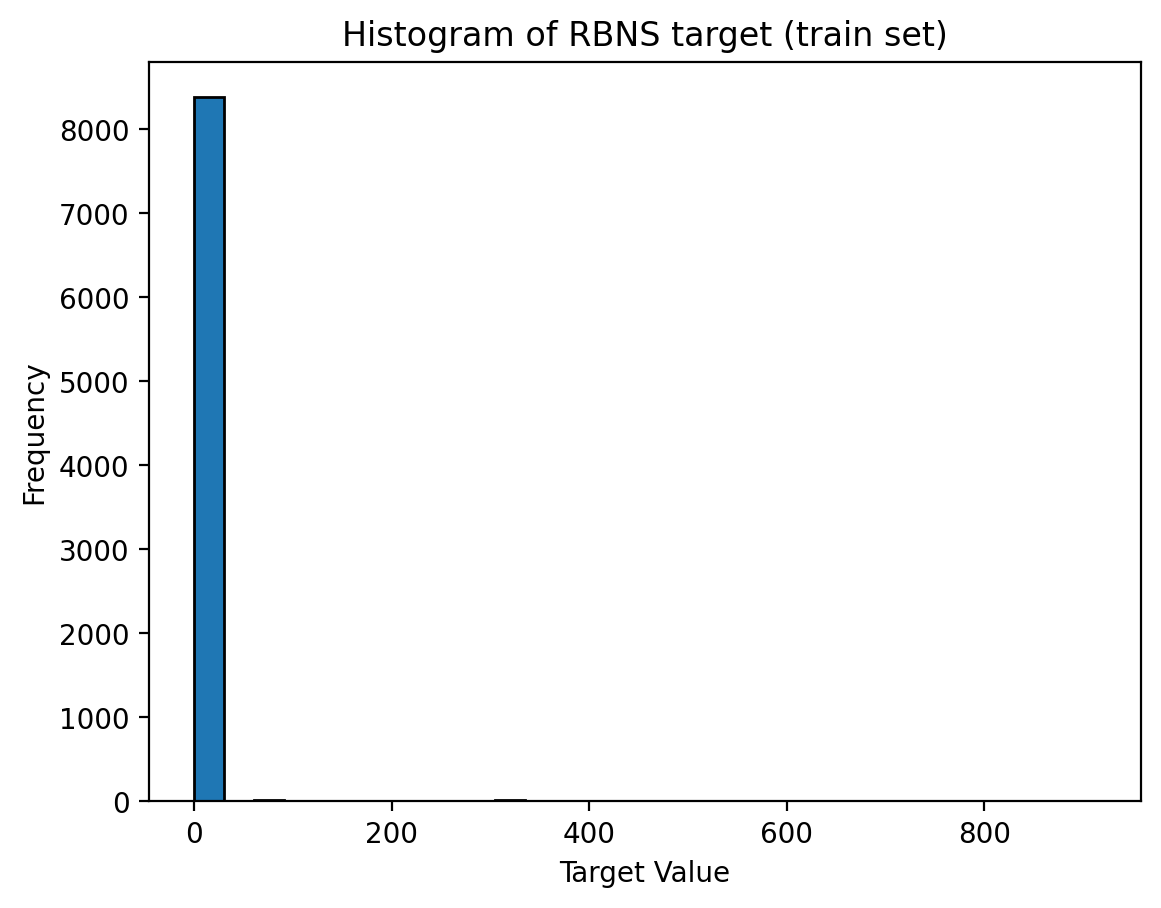

In [83]:
# 1. Summary statistics
print(y_train.describe())

# 2. Histogram
import matplotlib.pyplot as plt

plt.hist(y_train, bins=30, edgecolor='black')
plt.title("Histogram of RBNS target (train set)")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()


In [84]:
import xgboost as xgb
from sklearn.model_selection import KFold

# 1. Define parameters
params = {
    "objective": "reg:tweedie",
    "max_depth": 2,
    "subsample": 0.75,
    "colsample_bytree": 0.8,
    "min_child_weight": 10,
    "eta": 0.1
}

# 2. Set seed for repeatability
seed = 1984

# 3. Create 5-fold cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=xgb_RBNS_DMat_train,
    num_boost_round=500,
    nfold=5,
    seed=seed,
    early_stopping_rounds=10,
    verbose_eval=10,
    as_pandas=True,
    metrics="rmse"
)


[0]	train-rmse:52.24364+1.28242	test-rmse:52.02538+4.99751
[10]	train-rmse:51.68097+1.27203	test-rmse:51.51313+4.98985
[20]	train-rmse:51.26494+1.29009	test-rmse:51.22582+4.95863
[30]	train-rmse:51.00155+1.28630	test-rmse:51.05716+4.93513
[40]	train-rmse:50.83682+1.32184	test-rmse:50.97310+4.97002
[50]	train-rmse:50.69646+1.31451	test-rmse:51.05257+4.97029
[51]	train-rmse:50.68851+1.31320	test-rmse:51.05244+4.96944


In [85]:
# 1. Train the final XGBoost model
watchlist = [
    (xgb_RBNS_DMat_train, 'train'),
    (xgb_RBNS_DMat_test, 'test')
]

xgb_RBNS_Fit = xgb.train(
    params=params,
    dtrain=xgb_RBNS_DMat_train,
    num_boost_round=len(cv_results),  # or use cv_results.shape[0]
    evals=watchlist,
    verbose_eval=10
)

# 2. Generate predictions on the full dataset
dt_All_RBNS['preds_full'] = xgb_RBNS_Fit.predict(xgb_RBNS_DMat_all)


[0]	train-tweedie-nloglik@1.5:8.89299	test-tweedie-nloglik@1.5:30.53509
[10]	train-tweedie-nloglik@1.5:6.50085	test-tweedie-nloglik@1.5:24.22790
[20]	train-tweedie-nloglik@1.5:5.40339	test-tweedie-nloglik@1.5:25.56149
[30]	train-tweedie-nloglik@1.5:4.97059	test-tweedie-nloglik@1.5:35.13432
[40]	train-tweedie-nloglik@1.5:4.78930	test-tweedie-nloglik@1.5:54.65993
[41]	train-tweedie-nloglik@1.5:4.77246	test-tweedie-nloglik@1.5:58.76467


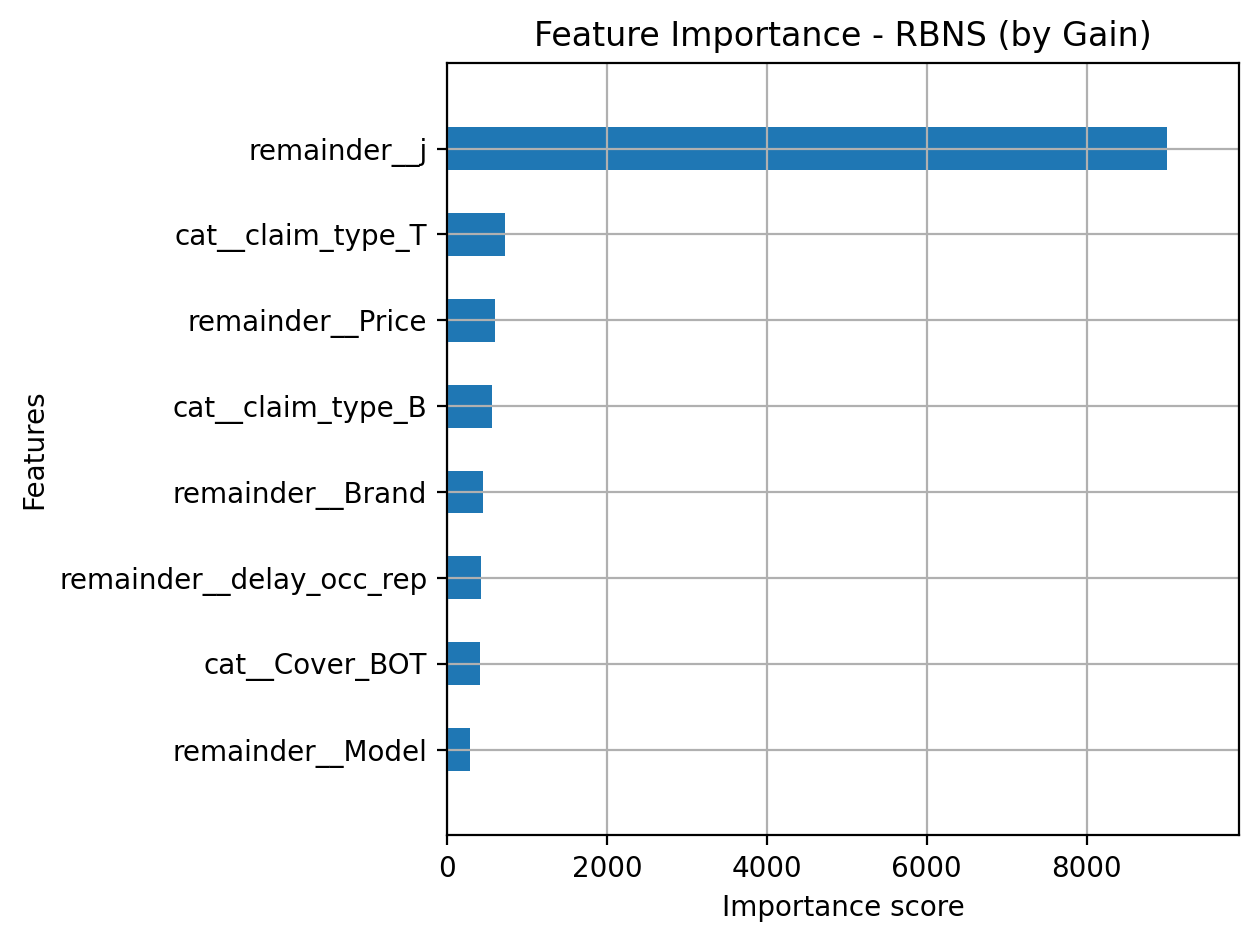

In [88]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance


# 2. Plot feature importance (by default: importance_type='weight', you can change it to 'gain')
xgb.plot_importance(
    booster=xgb_RBNS_Fit,
    importance_type='gain',  # matches R's default
    show_values=False,
    max_num_features=20,     # Optional: top N features
    height=0.5
)

plt.title("Feature Importance - RBNS (by Gain)")
plt.tight_layout()
plt.show()


C:\Users\Aayush Ranjan\AppData\Local\Temp\ipykernel_6324\2689907621.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NormalizedGain', y='Feature', data=feat_imp_df, palette='viridis')


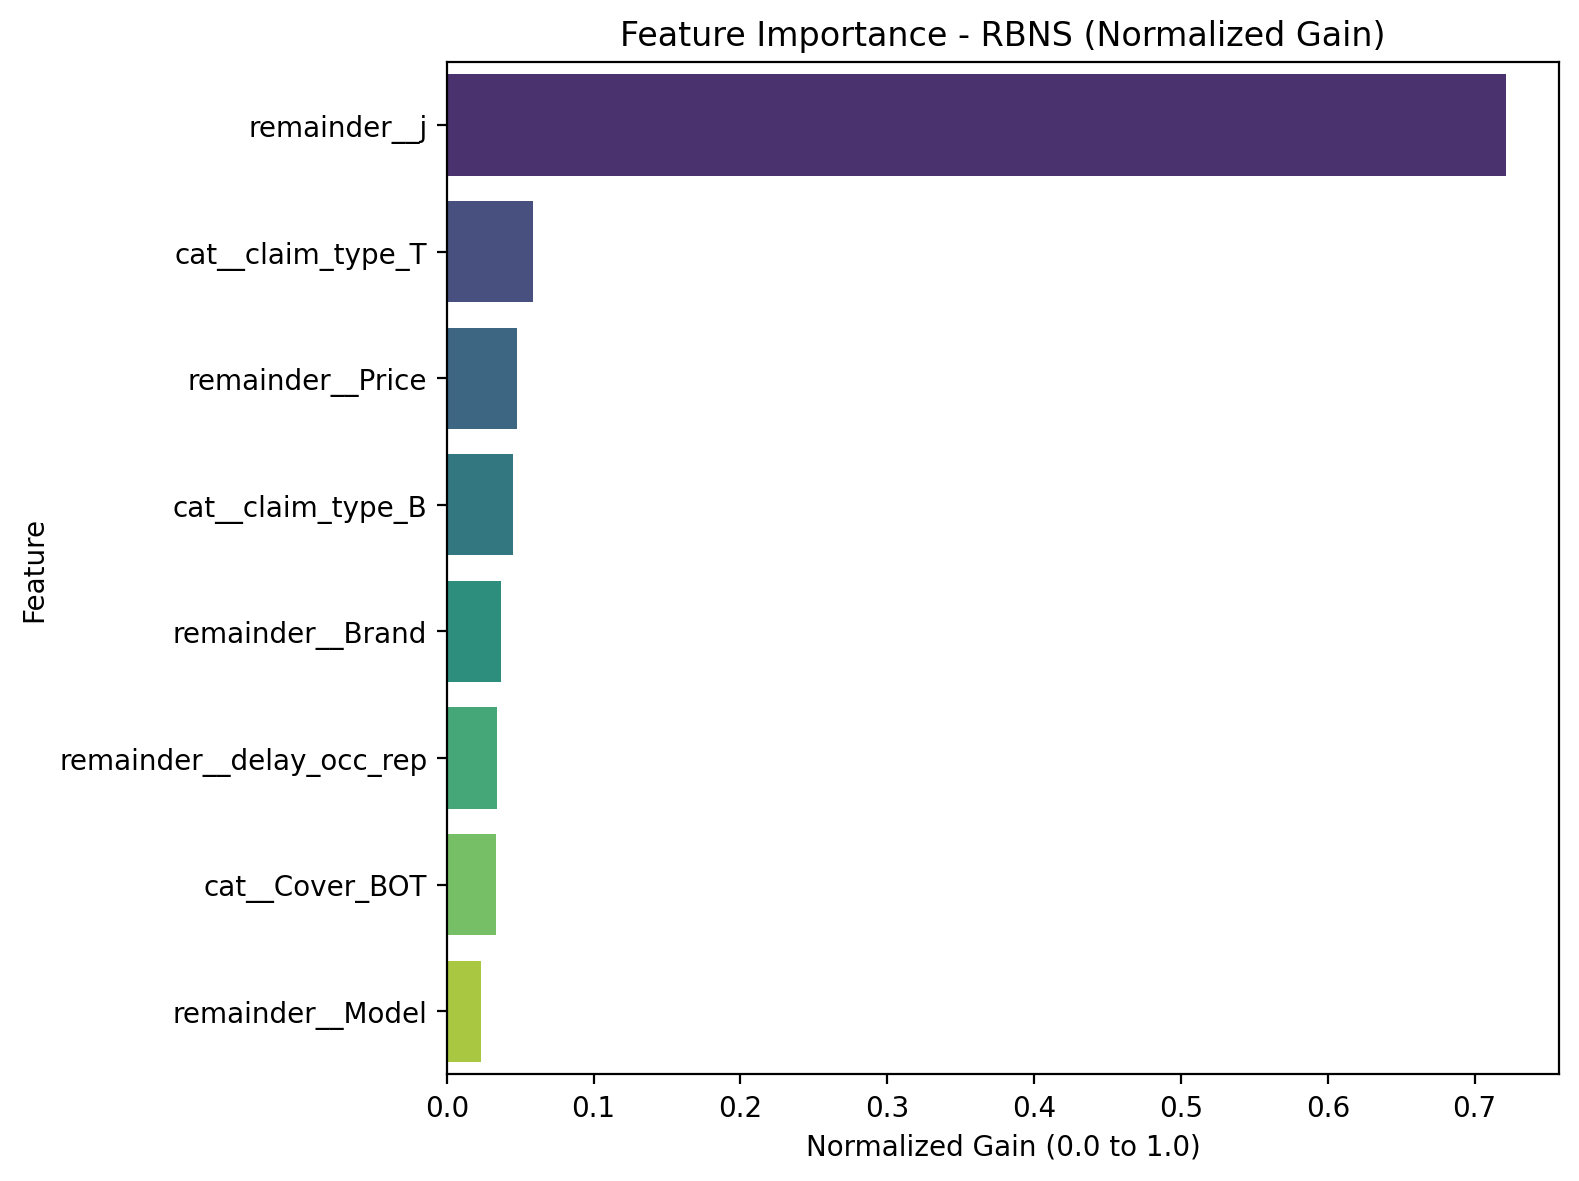

In [89]:
# 1. Get raw feature importance (by gain)
importance_dict = xgb_RBNS_Fit.get_score(importance_type='gain')

# 2. Convert to DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# 3. Normalize the gain to range [0, 1]
feat_imp_df['NormalizedGain'] = feat_imp_df['Gain'] / feat_imp_df['Gain'].sum()

# 4. Sort and pick top N (optional)
feat_imp_df = feat_imp_df.sort_values(by='NormalizedGain', ascending=False).head(20)

# 5. Plot using seaborn or matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x='NormalizedGain', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Feature Importance - RBNS (Normalized Gain)")
plt.xlabel("Normalized Gain (0.0 to 1.0)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

C:\Users\Aayush Ranjan\AppData\Local\Temp\ipykernel_6324\2594007717.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


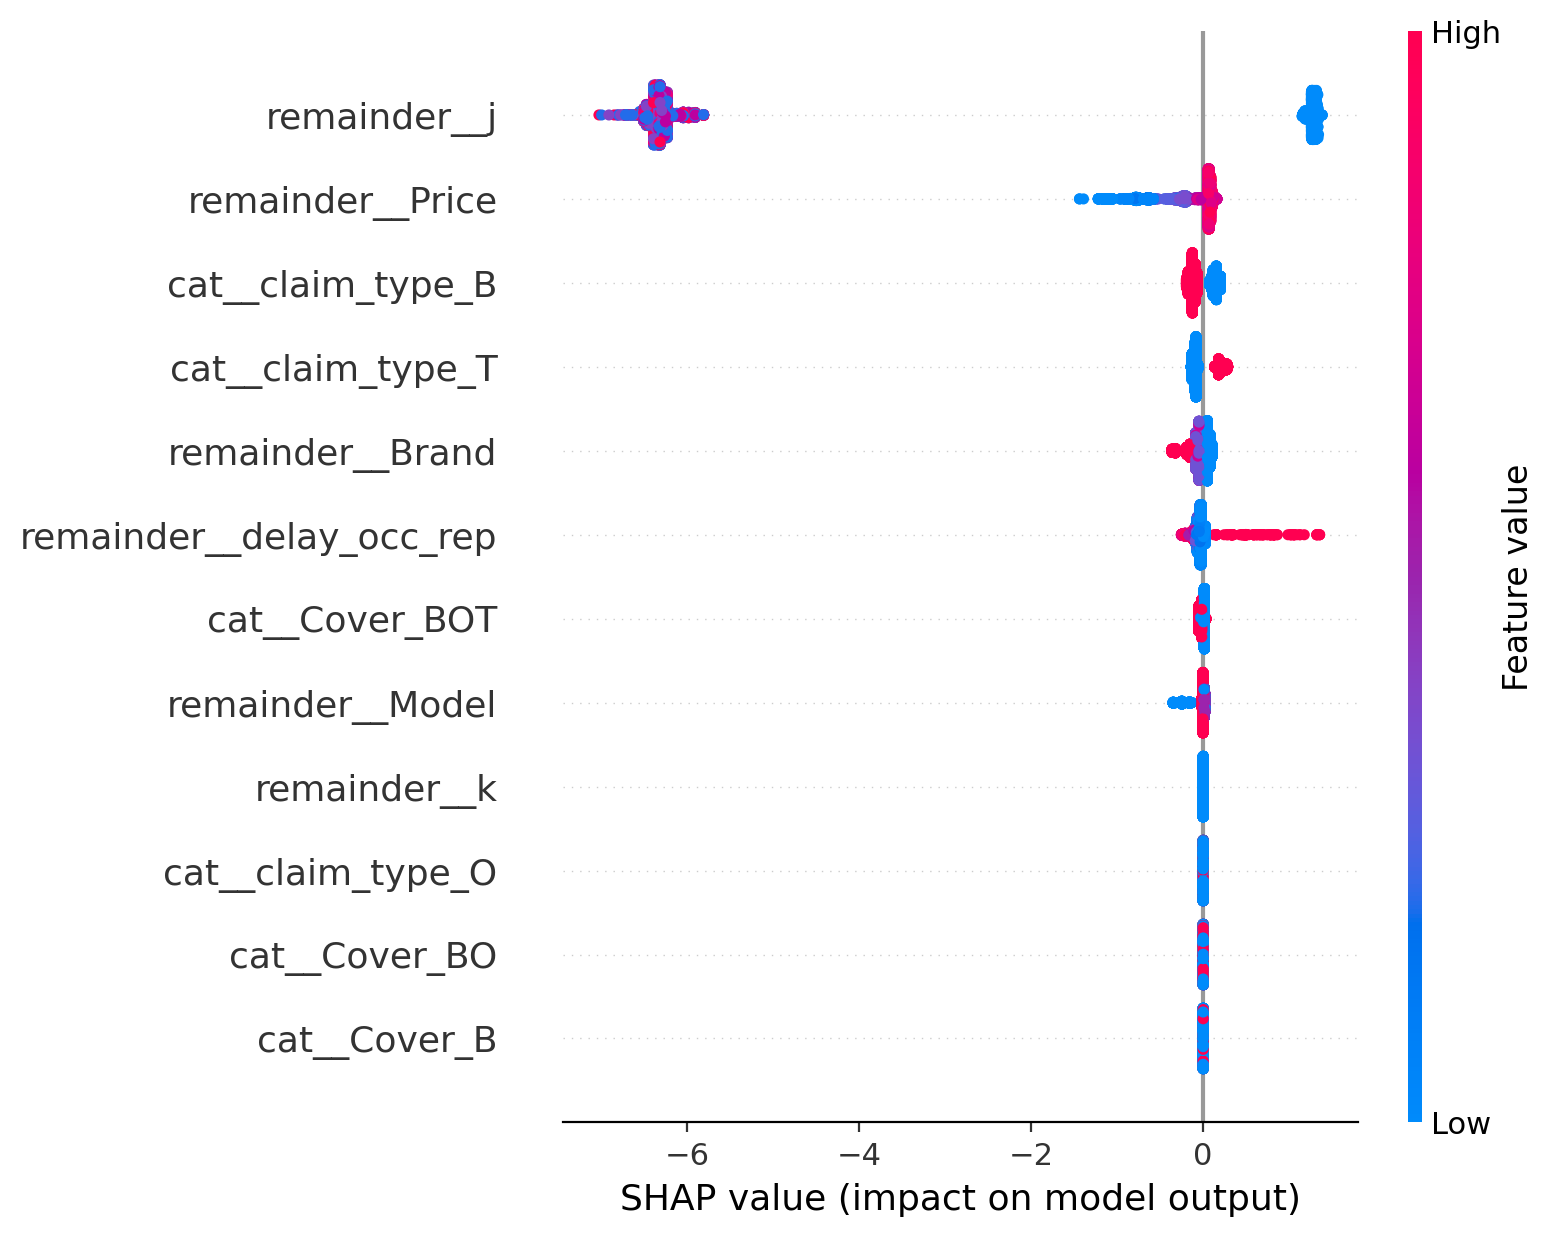

In [92]:
import shap
import numpy as np

# 1. Create SHAP explainer from trained XGBoost model
explainer = shap.TreeExplainer(xgb_RBNS_Fit)

# 2. Get SHAP values for training set
# X_train_encoded was used to train the model
shap_values = explainer.shap_values(X_train_encoded)

# 3. Plot summary
# Use feature_names from earlier to map correct names
shap.summary_plot(
    shap_values, 
    features=X_train_encoded, 
    feature_names=feature_names,
    plot_type='dot',      # equivalent to R's default
    max_display=20        # optional: top 20 features
)


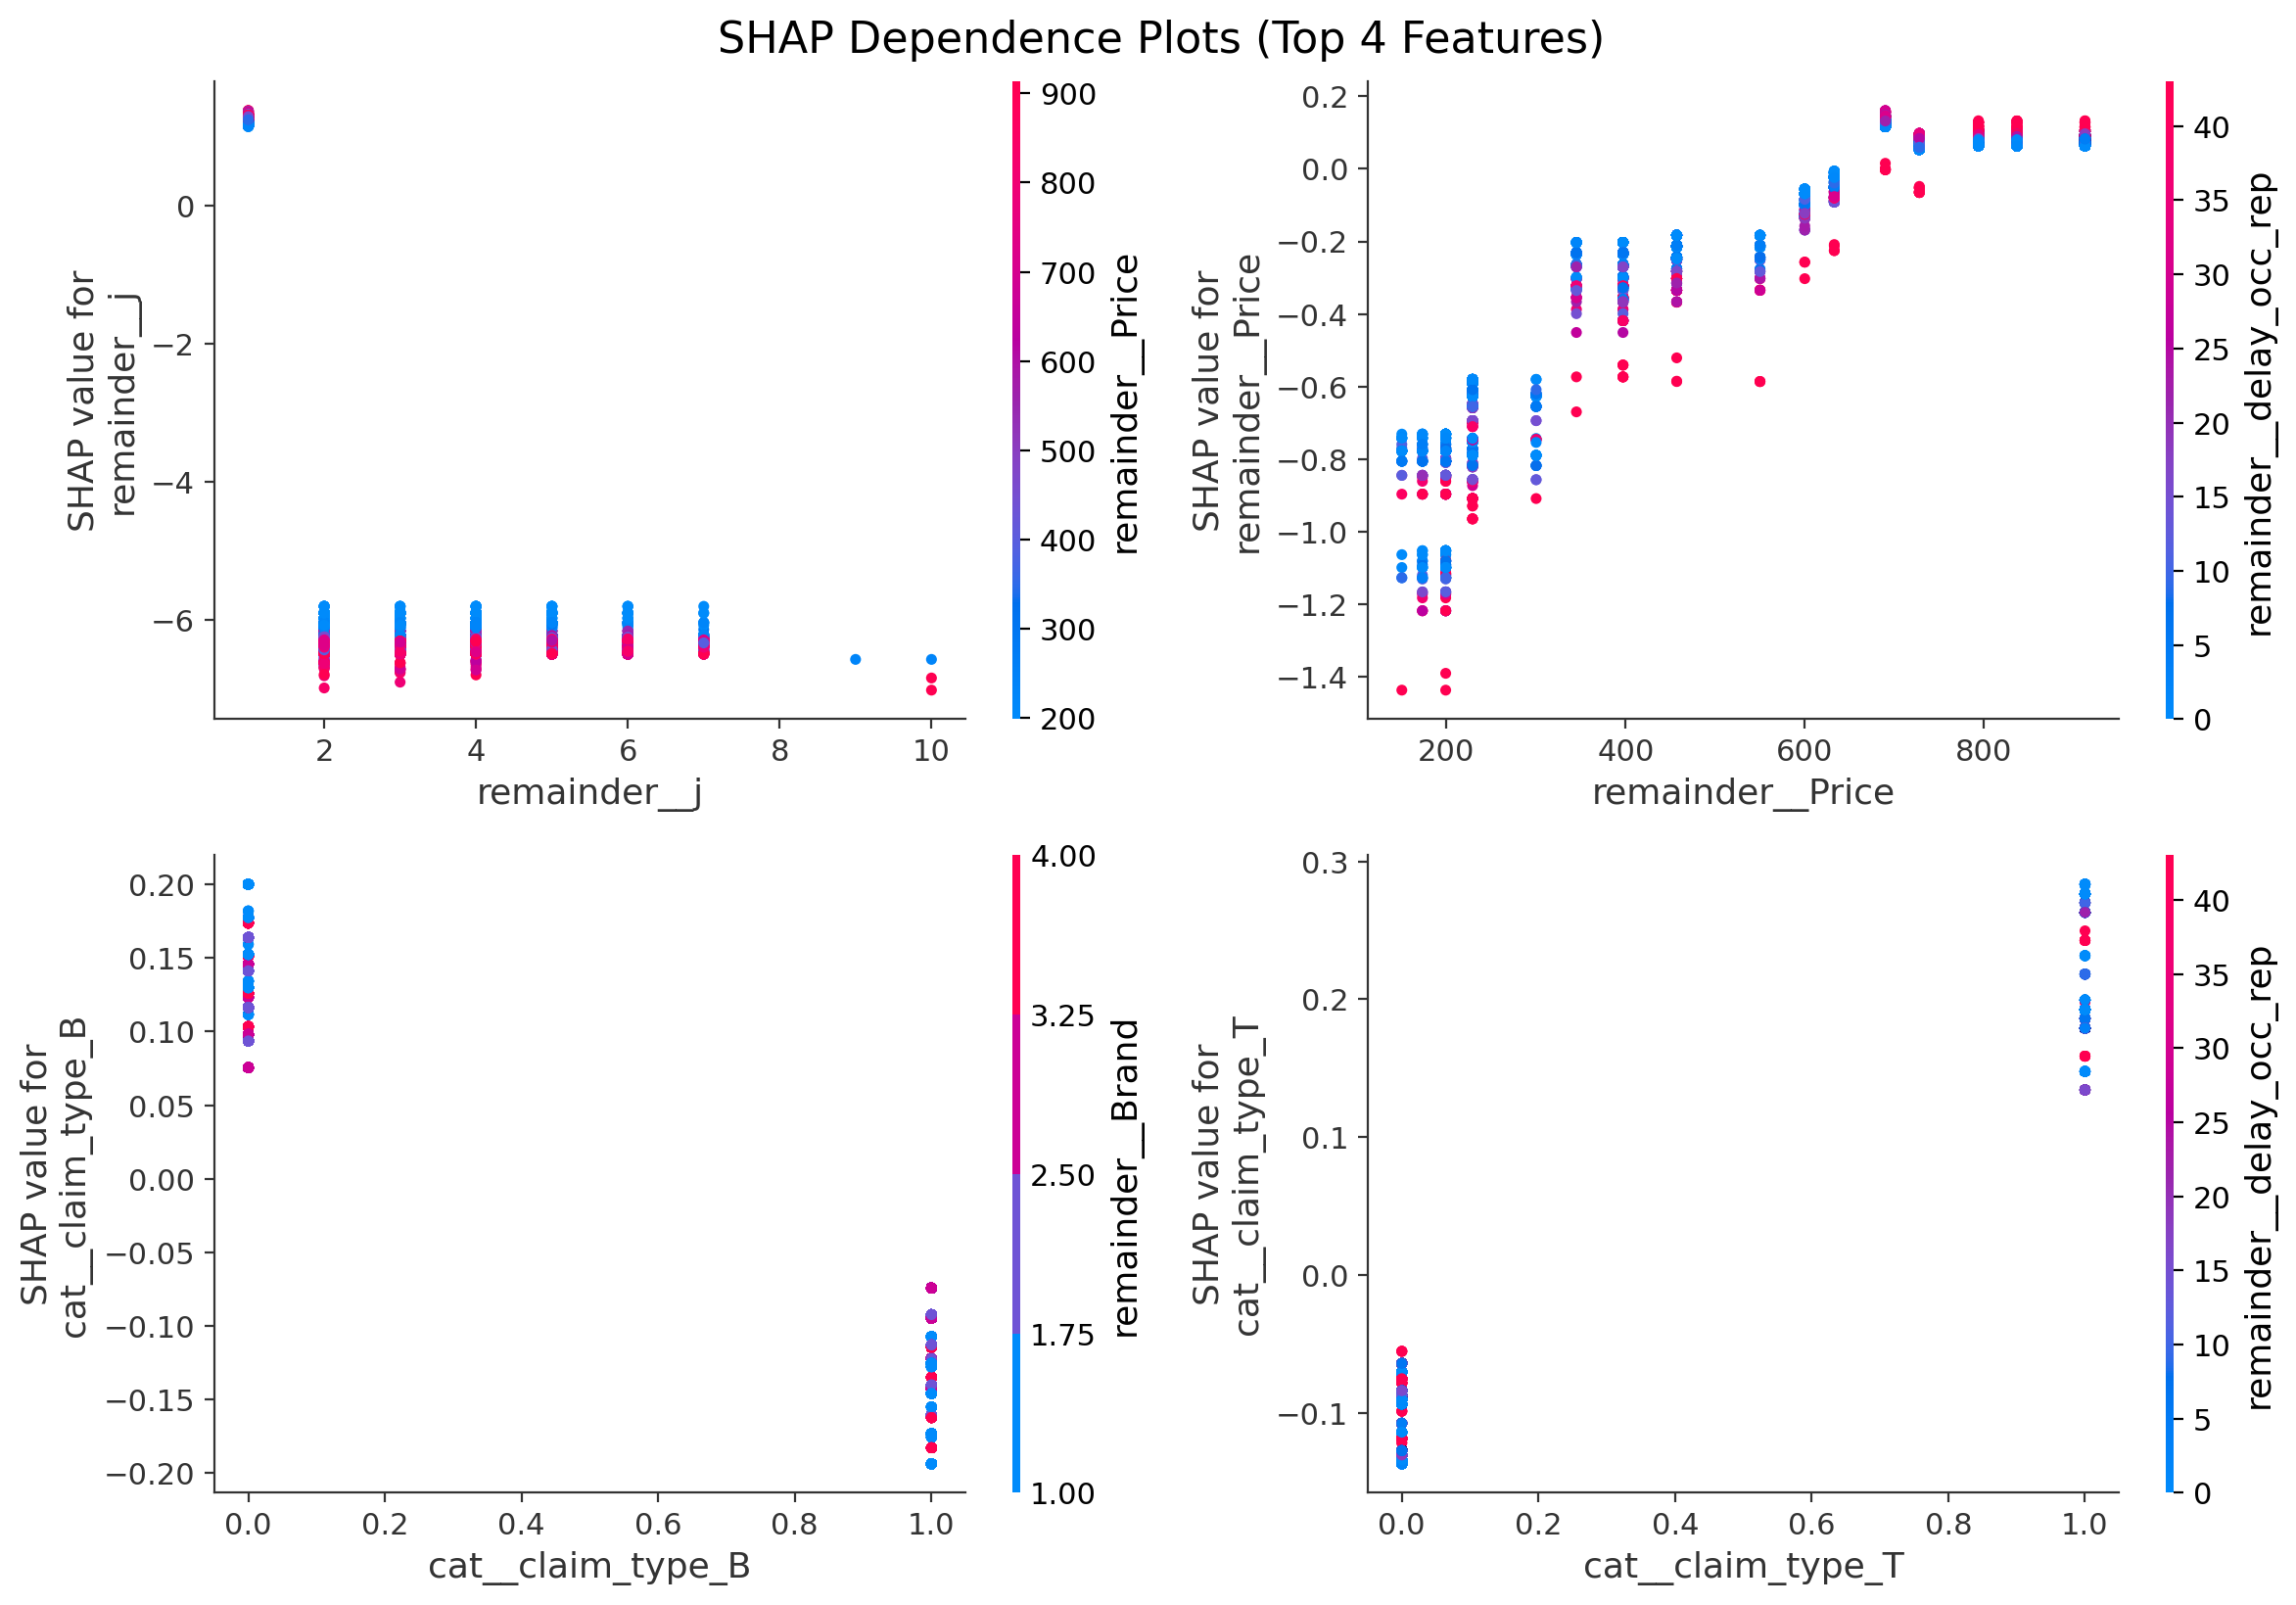

In [93]:
explainer = shap.TreeExplainer(xgb_RBNS_Fit)
shap_values = explainer.shap_values(X_train_encoded)

# Compute mean |SHAP| values to rank features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top4_indices = np.argsort(mean_abs_shap)[-4:][::-1]  # Top 4 feature indices
top4_features = [feature_names[i] for i in top4_indices]

# Create 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot SHAP dependence for top 4 features
for i, feature in enumerate(top4_features):
    shap.dependence_plot(
        ind=feature,
        shap_values=shap_values,
        features=X_train_encoded,
        feature_names=feature_names,
        ax=axs[i],
        show=False  # prevent immediate display
    )

# Final adjustments
plt.tight_layout()
plt.suptitle("SHAP Dependence Plots (Top 4 Features)", fontsize=16, y=1.02)
plt.show()

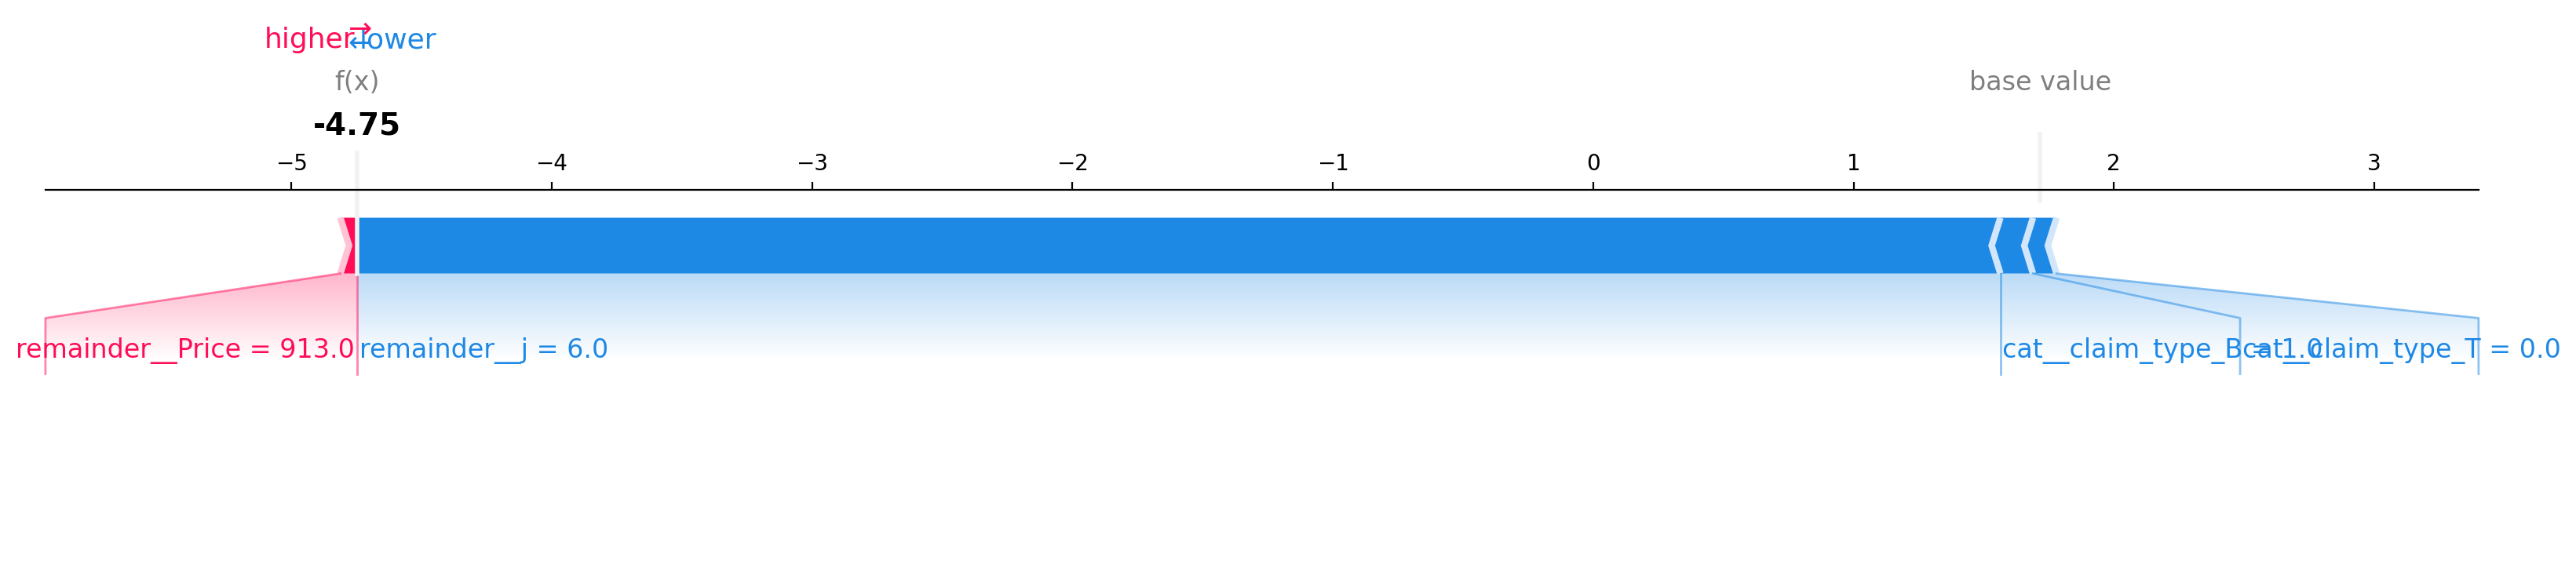

✅ Saved interactive SHAP force plot to 'force_plot_zoomed.html'


In [95]:

# 1. Create SHAP explainer
explainer = shap.Explainer(xgb_RBNS_Fit)

# 2. Get SHAP values (returns shap.Explanation)
shap_values = explainer(X_train_encoded, check_additivity=False)

# 3. Compute mean |SHAP| and get top 4 feature indices
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top4_indices = np.argsort(mean_abs_shap)[-4:][::-1]
top4_features = [feature_names[i] for i in top4_indices]

# 4. Slice 10 rows around a specific point (e.g., row 500)
zoom_index = 500
window_size = 5
force_data = shap_values[zoom_index - window_size : zoom_index + window_size]

# 5. Restrict to top 4 features
force_data.data = force_data.data[:, top4_indices]
force_data.values = force_data.values[:, top4_indices]
force_data.feature_names = top4_features

# ---------- OPTION 1: Single-row force plot using matplotlib ----------
# This works in notebooks (static plot)
shap.plots.force(
    force_data[0],  # show only one observation
    matplotlib=True,
    show=True
)

# ---------- OPTION 2: Multi-row interactive force plot in HTML ----------
# This opens in browser and supports scrolling, like R's stacked plot
shap.save_html("force_plot_zoomed.html", shap.plots.force(force_data))
print("✅ Saved interactive SHAP force plot to 'force_plot_zoomed.html'")


In [97]:
# 1. Create YYYY.MM string column from date_occur
dt_All_RBNS['date_occur_YYYYMM'] = dt_All_RBNS['date_occur'].dt.year + dt_All_RBNS['date_occur'].dt.month / 100
dt_All_RBNS['date_occur_YYYYMM'] = dt_All_RBNS['date_occur_YYYYMM'].astype(str)

# 2. Filter test rows and group by date_occur_YYYYMM
test_rows = rowList_RBNS['test']
dt_RBNS_summary = (
    dt_All_RBNS.loc[test_rows]
    .groupby('date_occur_YYYYMM', as_index=False)
    .agg(preds=('preds_full', 'sum'), target=('target', 'sum'))
)


In [98]:
from IPython.display import display, HTML

# 1. Append "Total" row (sum of numeric columns)
sum_row = pd.DataFrame({
    'date_occur_YYYYMM': ['Total'],
    'preds': [dt_RBNS_summary['preds'].sum()],
    'target': [dt_RBNS_summary['target'].sum()]
})

dt_RBNS_summary = pd.concat([dt_RBNS_summary, sum_row], ignore_index=True)

# 2. Add Diff and Diff_pcnt columns
dt_RBNS_summary['Diff'] = dt_RBNS_summary['preds'] - dt_RBNS_summary['target']
dt_RBNS_summary['Diff_pcnt'] = np.where(
    dt_RBNS_summary['target'] == 0,
    "N/A",
    (dt_RBNS_summary['Diff'] / dt_RBNS_summary['target']).apply(lambda x: f"{x:.1%}")
)

# 3. Format numeric columns (like kable format.args)
formatted = dt_RBNS_summary.copy()
formatted[['preds', 'target', 'Diff']] = formatted[['preds', 'target', 'Diff']].applymap(
    lambda x: f"{int(x):,}" if pd.notna(x) else ""
)

# 4. Display as scrollable HTML table
styled = formatted.style.set_table_attributes("style='display:inline'").set_table_styles([
    {"selector": "thead th", "props": "background-color: #f2f2f2; font-weight: bold;"},
    {"selector": "tbody td", "props": "padding: 4px;"}
]).hide(axis='index')

# Wrap in scroll box
html = f"<div style='overflow-x: auto; width: 100%'>{styled.to_html()}</div>"
display(HTML(html))

C:\Users\Aayush Ranjan\AppData\Local\Temp\ipykernel_6324\3457776164.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted[['preds', 'target', 'Diff']] = formatted[['preds', 'target', 'Diff']].applymap(


date_occur_YYYYMM,preds,target,Diff,Diff_pcnt
2016.03,101,648,-546,-84.4%
2016.04,134,834,-699,-83.9%
2016.05,583,"3,360","-2,776",-82.6%
2016.06,"1,494","11,641","-10,146",-87.2%
2016.07,"3,040","49,444","-46,403",-93.9%
2016.08,"15,591","301,421","-285,829",-94.8%
2016.09,"31,727","597,732","-566,004",-94.7%
Total,"52,672","965,080","-912,407",-94.5%
